# 📚 Exercise Session - Week 3: Attention + Transformers
**Main Topics**: Attention & Transformers for Sequence-to-Sequence Modeling

**Overview**

This week’s session dives into Transformers for sequence-to-sequence (Seq2Seq) tasks, with a special focus on machine translation and attention visualization. By the end, you will have built and trained a Transformer model capable of translating text from one language to another—and you’ll see how attention helps it learn alignments across tokens.

1. [**TASK A:** Transformer Implementation](#Task-A:-Transformer-Implementation)
- Build a BPE tokenizer
- Implement a Transformer encoder-decoder model using PyTorch

2. [**TASK B:** Train a Machine Translation Model](#Task-B:-Train-a-Machine-Translation-Model)
- Use Transformer from Task A to train a machine translation model
- Visualize the cross-attention weights

3. **Optional Extensions** 
- Learning Rate Scheduler: Try adding a scheduler (like Warmup or ReduceLROnPlateau) to potentially improve convergence.
- Periodic Validation: Every `m` batches or at epoch’s end, evaluate on a validation set to track loss or metrics like BLEU.
- Use PyTorch `DataLoader`

**Tips & Hints**
- **Overfitting on a Single Example**: If your model cannot easily learn one sample to near-perfect accuracy, it often indicates an implementation bug or mismatch in shapes/masks.
- **Masking**: Pay careful attention to causal masks in the decoder, ensuring the model does not see future tokens.
- **Debugging**: Print shapes and partial outputs, or watch the attention scores to confirm they behave as expected.


> **By the end of the session you will be able to:**
> - ✅  Implement an encoder-decoder Transformer model using PyTorch
> - ✅  Train your model on a machine translation corpus
> - ✅  Understand attention mechanism within the Transformer architecture
> - ✅  Be more interested in NLP 😉

## Task A: Transformer Implementation

**Quick Reminder**
We will be implementing the following encoder-decoder transformer architecture following the original [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper!

![Transformer Architecture](transformer_arch.png)

In this part, you will implement an encoder-decoder Transformer model using [Pytorch](https://pytorch.org/)

In [3]:
!pip install datasets
!pip install seaborn

# Transformer Architecture

In [4]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# For reproducibility
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # These layers transform the input embeddings to queries, keys, and values
        self.query_proj = nn.Linear(embed_dim, embed_dim)
        self.key_proj   = nn.Linear(embed_dim, embed_dim)
        self.value_proj = nn.Linear(embed_dim, embed_dim)

        # Final projection after concatenating heads
        self.out_proj   = nn.Linear(embed_dim, embed_dim)

        # Dropout for attention weights
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        """
        Args:
            query, key, value: Tensors of shape [batch_size, seq_len, embed_dim].
            mask: Optional tensor of shape [batch_size, 1, seq_len, seq_len] or 
                  [batch_size, num_heads, seq_len, seq_len] to mask attention.

        Returns:
            output: [batch_size, seq_len, embed_dim]
            attn_weights: [batch_size, num_heads, seq_len, seq_len]
        """
        batch_size = query.size(0)
        
        # 1) Linear projections of Q, K, V
        Q = self.query_proj(query)  # [batch_size, seq_len, embed_dim]
        K = self.key_proj(key)      # [batch_size, seq_len, embed_dim]
        V = self.value_proj(value)  # [batch_size, seq_len, embed_dim]

        # 2) Reshape into [batch_size, num_heads, seq_len, head_dim]
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        # Now Q, K, V each have shape [batch_size, num_heads, seq_len, head_dim]

        # 3) Scaled dot-product attention
        #    attention_scores = (Q @ K^T) / sqrt(head_dim)
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        # attention_scores: [batch_size, num_heads, seq_len, seq_len]

        # Optional mask
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        # Softmax along the last dimension (seq_len of K)
        attn_weights = F.softmax(attention_scores, dim=-1)
        # Apply dropout to attention weights
        attn_weights = self.dropout(attn_weights)

        # Multiply by V
        # attention_output shape: [batch_size, num_heads, seq_len, head_dim]
        attention_output = torch.matmul(attn_weights, V)

        # 4) Concat heads: transpose back and then reshape
        # From [batch_size, num_heads, seq_len, head_dim] -> [batch_size, seq_len, embed_dim]
        attention_output = attention_output.transpose(1, 2).contiguous()
        attention_output = attention_output.view(batch_size, -1, self.embed_dim)

        # 5) Final linear projection
        output = self.out_proj(attention_output)
        
        return output, attn_weights


In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout=0):
        super(EncoderLayer, self).__init__()

        self.self_attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.linear1   = nn.Linear(embed_dim, hidden_dim)
        self.linear2   = nn.Linear(hidden_dim, embed_dim)
        self.norm1     = nn.LayerNorm(embed_dim)
        self.norm2     = nn.LayerNorm(embed_dim)
        self.dropout1  = nn.Dropout(dropout)
        self.dropout2  = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # x shape: [batch_size, seq_len, embed_dim]
        
        # 1) Multi-head self-attention
        attn_output, _ = self.self_attn(x, x, x, mask=mask)
        x = x + attn_output  # residual
        x = self.norm1(x)

        # 2) Feed-forward
        ff_output = self.linear2(F.relu(self.linear1(x)))
        x = x + ff_output  # residual
        x = self.norm2(x)

        return x

In [7]:
class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout=0):
        super(DecoderLayer, self).__init__()

        self.self_attn        = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.cross_attn       = MultiHeadAttention(embed_dim, num_heads, dropout)
        
        self.linear1          = nn.Linear(embed_dim, hidden_dim)
        self.linear2          = nn.Linear(hidden_dim, embed_dim)

        self.norm1            = nn.LayerNorm(embed_dim)
        self.norm2            = nn.LayerNorm(embed_dim)
        self.norm3            = nn.LayerNorm(embed_dim)


    def forward(self, x, enc_output, tgt_mask=None, cross_attn_mask=None):
        """
        x: [batch_size, tgt_seq_len, embed_dim] (decoder input embeddings)
        enc_output: [batch_size, src_seq_len, embed_dim] (encoder output)
        tgt_mask: mask for target self-attention
        cross_attn_mask: mask for encoder-decoder attention
        """
        # 1) Masked self-attention (decoder)
        attn_output, _ = self.self_attn(x, x, x, mask=tgt_mask)
        x = x + attn_output
        x = self.norm1(x)

        # 2) Cross-attention (encoder-decoder)
        cross_attn_output, attn_weights = self.cross_attn(x, enc_output, enc_output, mask=cross_attn_mask)
        x = x + cross_attn_output
        x = self.norm2(x)

        # 3) Feed-forward
        ff_output = self.linear2(F.relu(self.linear1(x)))
        x = x + ff_output
        x = self.norm3(x)

        return x, attn_weights

In [8]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, max_len=1024, dropout=0):
        super(Encoder, self).__init__()
        self.embed_dim = embed_dim
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = nn.Embedding(max_len, embed_dim)
        self.layers = nn.ModuleList([
            EncoderLayer(embed_dim, num_heads, hidden_dim, dropout) for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        """
        src: [batch_size, src_seq_len]
        src_mask: (optional)
        """
        x = self.embedding(src) * math.sqrt(self.embed_dim)
        x = x + self.pos_encoding(torch.arange(src.size(1)).to(src.device)).unsqueeze(0)

        for layer in self.layers:
            x = layer(x, mask=src_mask)
        
        return x  # shape: [batch_size, src_seq_len, embed_dim]


class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, max_len=1024, dropout=0):
        super(Decoder, self).__init__()
        self.embed_dim = embed_dim

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = nn.Embedding(max_len, embed_dim)
        self.layers = nn.ModuleList([
            DecoderLayer(embed_dim, num_heads, hidden_dim, dropout) for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(embed_dim, vocab_size)

    def forward(self, tgt, enc_output, tgt_mask=None, cross_attn_mask=None):
        """
        tgt: [batch_size, tgt_seq_len]
        enc_output: [batch_size, src_seq_len, embed_dim]
        """
        x = self.embedding(tgt) * math.sqrt(self.embed_dim)
        x = x + self.pos_encoding(torch.arange(tgt.size(1)).to(tgt.device)).unsqueeze(0)

        attn_weights = None
        for layer in self.layers:
            x, attn_weights = layer(x, enc_output, tgt_mask=tgt_mask, cross_attn_mask=cross_attn_mask)

        # Final projection to vocabulary
        logits = self.out_proj(x)  # [batch_size, tgt_seq_len, vocab_size]
        return logits, attn_weights

In [9]:
import torch

def build_causal_mask(seq_len, device=None):
    """
    Returns a 2D causal mask of shape [seq_len, seq_len], 
    where True means 'allowed to attend' and False means 'disallowed'.
    """
    return torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool, device=device))

def expand_causal_mask(causal_2d, batch_size, num_heads):
    # causal_2d: shape [seq_len, seq_len]
    # expand to [batch_size, num_heads, seq_len, seq_len]
    causal_4d = causal_2d.unsqueeze(0).unsqueeze(0)  # => [1,1,seq_len,seq_len]
    causal_4d = causal_4d.expand(batch_size, num_heads, causal_2d.size(0), causal_2d.size(1))
    return causal_4d

def expand_padding_mask(pad_mask_2d, num_heads):
    # pad_mask_2d: shape [batch_size, seq_len], 1 = valid, 0 = pad
    # step 1) Convert to bool if needed
    pad_mask_bool = pad_mask_2d.bool()  # shape [batch_size, seq_len]
    # step 2) unsqueeze => [batch_size, 1, 1, seq_len]
    pad_mask_4d = pad_mask_bool.unsqueeze(1).unsqueeze(2)
    # step 3) broadcast across the query dimension
    batch_size, _, _, seq_len = pad_mask_4d.shape
    pad_mask_4d = pad_mask_4d.expand(batch_size, num_heads, seq_len, seq_len)
    return pad_mask_4d


def build_decoder_mask(
    pad_mask_2d: torch.Tensor, 
    num_heads: int
):
    """
    Combine the target padding mask with the causal mask 
    to produce a final decoder mask of shape:
    [batch_size, num_heads, seq_len, seq_len], 
    where True means 'allowed', False means 'masked out'.
    """
    device = pad_mask_2d.device
    batch_size, seq_len = pad_mask_2d.shape

    # 1) Build the 2D causal mask
    causal_2d = build_causal_mask(seq_len, device=device)

    # 2) Expand to 4D
    causal_4d = expand_causal_mask(causal_2d, batch_size, num_heads)

    # 3) Expand the padding mask to 4D
    pad_4d = expand_padding_mask(pad_mask_2d, num_heads)

    # 4) Final mask = causal AND pad
    final_mask = causal_4d & pad_4d  # shape [batch_size, num_heads, seq_len, seq_len]
    return final_mask


In [10]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_dim=512, num_heads=8, hidden_dim=2048, 
                 num_layers=6, dropout=0):
        super(Transformer, self).__init__()
        self.num_heads = num_heads
        self.encoder = Encoder(src_vocab_size, embed_dim, num_heads, hidden_dim, num_layers, dropout=dropout)
        self.decoder = Decoder(tgt_vocab_size, embed_dim, num_heads, hidden_dim, num_layers, dropout=dropout)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, cross_attn_mask=None):

        if src_mask is not None:
            src_mask = src_mask[:, None, None, :]
            src_mask = src_mask.expand(-1, -1, src_mask.size(-1), -1)

        tgt_mask = build_decoder_mask(tgt_mask, num_heads=self.num_heads)

        enc_output = self.encoder(src, src_mask)
        logits, attn_weights = self.decoder(tgt, enc_output, tgt_mask, cross_attn_mask)
        return logits, attn_weights

## Task B: Train a Machine Translation Model

In [11]:
import torch
import numpy as np
from datasets import load_from_disk

# Load the dataset
dataset = load_from_disk("wmt14_fr_en")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 100000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 3003
    })
})


### Build a BPE Tokenizer

> You will learn about BPE tokenization later in the semester. Here we provide you with the code necessary to train your own tokenizer.

In [12]:
from tokenizers import ByteLevelBPETokenizer

def batch_iterator(dataset, batch_size=1000):
    """
    Yields batches of text from the Hugging Face dataset.
    Args:
        dataset: a huggingface dataset split (e.g. train_dataset)
        batch_size: how many samples per batch
        text_column: name of the column containing the text
    """
    for i in range(0, len(dataset), batch_size):
        # Extract a batch of examples
        batch = dataset[i : i + batch_size]

        # 'batch' is now a list of strings (if text_column is indeed text).
        yield batch


fr_training_set = [dataset["train"][i]['translation']['fr'] for i in range(100_000)]
en_training_set = [dataset["train"][i]['translation']['en'] for i in range(100_000)]
training_set = en_training_set + fr_training_set

# 1) Initialize tokenizer
tokenizer = ByteLevelBPETokenizer()

# 2) Train from the iterator
tokenizer.train_from_iterator(
    iterator=batch_iterator(training_set, batch_size=1000),
    vocab_size=32_000,  # Choose your vocab size
    min_frequency=2,
    special_tokens=["<pad>", "<unk>", "<s>", "</s>"]  # Or any set of special tokens you prefer
)

# 3) Save the tokenizer
tokenizer.save("my_bytelevel_tokenizer.json")

In [13]:
# Load the tokenizer
from transformers import PreTrainedTokenizerFast

hf_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file="my_bytelevel_tokenizer.json",  # or the two files from the BPE approach
    bos_token="<s>",
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>"
)

encoded_input = hf_tokenizer("The quick brown fox", return_tensors="pt", add_special_tokens=True)
decoded_output = hf_tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][0])

print(encoded_input)
print(decoded_output)

{'input_ids': tensor([[ 439, 8722, 6667, 1727,  291, 3255]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}
['The', 'Ġquick', 'Ġbro', 'wn', 'Ġf', 'ox']


### Define Hyperparameters

In [14]:
# Training parameters
epochs = 5
batch_size = 16
max_len = 256
learning_rate = 1e-4

# Model parameters
embed_dim = 512
num_heads = 8
hidden_dim = 2048
num_layers = 4

### Training Loop

In [15]:
# Initialize the model
model = Transformer(
    src_vocab_size=hf_tokenizer.vocab_size, 
    tgt_vocab_size=hf_tokenizer.vocab_size,
    num_layers=num_layers,
    embed_dim=embed_dim,
    num_heads=num_heads,
    hidden_dim=hidden_dim
)
model.to(device)

print(f"> Number of parameters in the model: {sum(p.numel() for p in model.parameters()):,}")

num_batches = int(np.ceil(len(dataset['train']) / batch_size))

loss_fn = nn.CrossEntropyLoss(ignore_index=hf_tokenizer.pad_token_id)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

train_losses = []

model.train()
for epoch_num in range(epochs):

    for batch_idx in range(num_batches):

        train_batch = dataset['train'][batch_idx * batch_size: (batch_idx + 1) * batch_size]['translation']

        src_train = [train_batch[i]['fr'] for i in range(len(train_batch))]
        tgt_train = [train_batch[i]['en'] for i in range(len(train_batch))]
        
        src_tokens = hf_tokenizer(src_train, return_tensors='pt', padding=True, truncation=True, max_length=max_len).to(device)
        tgt_tokens = hf_tokenizer(tgt_train, return_tensors='pt', padding=True, truncation=True, max_length=max_len).to(device)

        # Prepend BOS token to target
        tgt_tokens["input_ids"] = torch.cat([
            torch.full_like(tgt_tokens["input_ids"][:, :1], hf_tokenizer.bos_token_id), 
            tgt_tokens["input_ids"][:, :-1]
        ], dim=1)

        logits, _ = model(
            src=src_tokens['input_ids'],
            tgt=tgt_tokens["input_ids"],
            src_mask=src_tokens["attention_mask"],
            tgt_mask=tgt_tokens["attention_mask"],
        )

        # shift labels to the right
        labels = tgt_tokens["input_ids"][:, 1:].contiguous()
        logits = logits[:, :-1].contiguous()

        optimizer.zero_grad()
        loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch_num}, Batch {batch_idx}/{num_batches}, Loss: {loss.item()}", end='\r')
        train_losses.append(loss.item())

        # if (batch_idx+1) % 200 == 0:
        #     print("Saving model...")
        #     torch.save(model.state_dict(), "transformer_model.pt")
    
    print(f"Epoch {epoch_num}, Loss: {np.mean(train_losses):.4f}")

torch.save(model.state_dict(), "transformer_model.pt")

> Number of parameters in the model: 79,658,240


KeyboardInterrupt: 

### Plot Training Loss Curve

Text(0.5, 1.0, 'Training Loss')

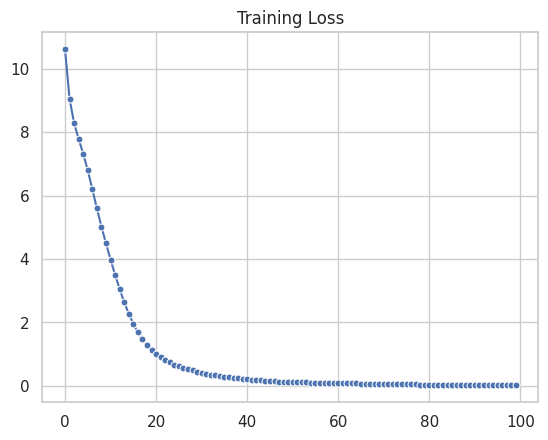

In [ ]:
# Plot loss
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
sns.lineplot(x=range(len(train_losses)), y=train_losses, marker='o', markersize=5)
plt.title("Training Loss")

### Generate Some Examples

Generate using greedy decoding. You will learn more about it in class later in the semester.

Here is a [link for a checkpoint](https://drive.google.com/file/d/130dDwMBJGhvSEFQdHkxaU-R5IjlSbO2j/view?usp=sharing) that you can use for prediction and attention weight visualization.
It was trained using the following configuration
```
embed_dim = 512
num_heads = 8
hidden_dim = 2048
num_layers = 4
vocab_size = 32000
```

In [22]:
# Load the model
model = Transformer(
    src_vocab_size=hf_tokenizer.vocab_size, 
    tgt_vocab_size=hf_tokenizer.vocab_size,
    num_layers=num_layers,
    embed_dim=embed_dim,
    num_heads=num_heads,
    hidden_dim=hidden_dim
)
model.to(device)
import os

# Print the current working directory
print("Current Directory:", os.getcwd())

# List all files in the current directory
print("Files in Directory:", os.listdir(os.getcwd()))
state_dict = torch.load("transformer_model.pth")
model.load_state_dict(state_dict)

src_val = [dataset['train'][i]['translation']['fr'] for i in range(5)]
tgt_val = [dataset['train'][i]['translation']['en'] for i in range(5)]

src_tokens_val = hf_tokenizer(src_val, return_tensors='pt', padding=True, truncation=True, max_length=max_len).to(device)

model.eval()
with torch.no_grad():
    for i in range(5):
        # Prepare inputs
        src = src_tokens_val['input_ids'][i].unsqueeze(0).to(device)
        tgt = torch.tensor([[hf_tokenizer.bos_token_id]], dtype=torch.long, device=device)

        # Greedy decode up to max_len
        for step in range(max_len):
            # Create tgt padding mask
            tgt_mask = torch.ones_like(tgt).bool().to(device)

            # Forward pass
            logits, _ = model(src, tgt, tgt_mask=tgt_mask)

            # Get the most probable token at the current step
            next_token = logits[:, -1, :].argmax(dim=-1)

            # Append
            tgt = torch.cat([tgt, next_token.unsqueeze(-1)], dim=1)

            # End conditions
            if next_token.item() in [hf_tokenizer.eos_token_id, hf_tokenizer.pad_token_id]:
                break

        # Decode
        translation = hf_tokenizer.decode(tgt[0], skip_special_tokens=True)

        print(f"Example {i+1}:")
        print(f"  Source:      {src_val[i]}")
        print(f"  Translation: {translation}")
        print(f"  Target:      {tgt_val[i]}\n")

Current Directory: /Users/gattimartina/Documents/EPFL/Master/MA2/cs-552-modern-nlp/Exercises/Week 3
Files in Directory: ['.DS_Store', 'wmt14_fr_en', 'transformer_arch.png', 'Week-3-Solution.ipynb', 'transformer_model.pth', 'my_bytelevel_tokenizer.json', 'Week-3-Exercise.ipynb']


RuntimeError: Error(s) in loading state_dict for Transformer:
	Missing key(s) in state_dict: "encoder.pos_encoding.weight", "encoder.layers.2.self_attn.query_proj.weight", "encoder.layers.2.self_attn.query_proj.bias", "encoder.layers.2.self_attn.key_proj.weight", "encoder.layers.2.self_attn.key_proj.bias", "encoder.layers.2.self_attn.value_proj.weight", "encoder.layers.2.self_attn.value_proj.bias", "encoder.layers.2.self_attn.out_proj.weight", "encoder.layers.2.self_attn.out_proj.bias", "encoder.layers.2.linear1.weight", "encoder.layers.2.linear1.bias", "encoder.layers.2.linear2.weight", "encoder.layers.2.linear2.bias", "encoder.layers.2.norm1.weight", "encoder.layers.2.norm1.bias", "encoder.layers.2.norm2.weight", "encoder.layers.2.norm2.bias", "encoder.layers.3.self_attn.query_proj.weight", "encoder.layers.3.self_attn.query_proj.bias", "encoder.layers.3.self_attn.key_proj.weight", "encoder.layers.3.self_attn.key_proj.bias", "encoder.layers.3.self_attn.value_proj.weight", "encoder.layers.3.self_attn.value_proj.bias", "encoder.layers.3.self_attn.out_proj.weight", "encoder.layers.3.self_attn.out_proj.bias", "encoder.layers.3.linear1.weight", "encoder.layers.3.linear1.bias", "encoder.layers.3.linear2.weight", "encoder.layers.3.linear2.bias", "encoder.layers.3.norm1.weight", "encoder.layers.3.norm1.bias", "encoder.layers.3.norm2.weight", "encoder.layers.3.norm2.bias", "decoder.pos_encoding.weight", "decoder.layers.2.self_attn.query_proj.weight", "decoder.layers.2.self_attn.query_proj.bias", "decoder.layers.2.self_attn.key_proj.weight", "decoder.layers.2.self_attn.key_proj.bias", "decoder.layers.2.self_attn.value_proj.weight", "decoder.layers.2.self_attn.value_proj.bias", "decoder.layers.2.self_attn.out_proj.weight", "decoder.layers.2.self_attn.out_proj.bias", "decoder.layers.2.cross_attn.query_proj.weight", "decoder.layers.2.cross_attn.query_proj.bias", "decoder.layers.2.cross_attn.key_proj.weight", "decoder.layers.2.cross_attn.key_proj.bias", "decoder.layers.2.cross_attn.value_proj.weight", "decoder.layers.2.cross_attn.value_proj.bias", "decoder.layers.2.cross_attn.out_proj.weight", "decoder.layers.2.cross_attn.out_proj.bias", "decoder.layers.2.linear1.weight", "decoder.layers.2.linear1.bias", "decoder.layers.2.linear2.weight", "decoder.layers.2.linear2.bias", "decoder.layers.2.norm1.weight", "decoder.layers.2.norm1.bias", "decoder.layers.2.norm2.weight", "decoder.layers.2.norm2.bias", "decoder.layers.2.norm3.weight", "decoder.layers.2.norm3.bias", "decoder.layers.3.self_attn.query_proj.weight", "decoder.layers.3.self_attn.query_proj.bias", "decoder.layers.3.self_attn.key_proj.weight", "decoder.layers.3.self_attn.key_proj.bias", "decoder.layers.3.self_attn.value_proj.weight", "decoder.layers.3.self_attn.value_proj.bias", "decoder.layers.3.self_attn.out_proj.weight", "decoder.layers.3.self_attn.out_proj.bias", "decoder.layers.3.cross_attn.query_proj.weight", "decoder.layers.3.cross_attn.query_proj.bias", "decoder.layers.3.cross_attn.key_proj.weight", "decoder.layers.3.cross_attn.key_proj.bias", "decoder.layers.3.cross_attn.value_proj.weight", "decoder.layers.3.cross_attn.value_proj.bias", "decoder.layers.3.cross_attn.out_proj.weight", "decoder.layers.3.cross_attn.out_proj.bias", "decoder.layers.3.linear1.weight", "decoder.layers.3.linear1.bias", "decoder.layers.3.linear2.weight", "decoder.layers.3.linear2.bias", "decoder.layers.3.norm1.weight", "decoder.layers.3.norm1.bias", "decoder.layers.3.norm2.weight", "decoder.layers.3.norm2.bias", "decoder.layers.3.norm3.weight", "decoder.layers.3.norm3.bias". 
	Unexpected key(s) in state_dict: "encoder.pos_encoding.pe", "decoder.pos_encoding.pe". 
	size mismatch for encoder.embedding.weight: copying a param with shape torch.Size([50265, 512]) from checkpoint, the shape in current model is torch.Size([32000, 512]).
	size mismatch for encoder.layers.0.linear1.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([2048, 512]).
	size mismatch for encoder.layers.0.linear1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layers.0.linear2.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([512, 2048]).
	size mismatch for encoder.layers.1.linear1.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([2048, 512]).
	size mismatch for encoder.layers.1.linear1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for encoder.layers.1.linear2.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([512, 2048]).
	size mismatch for decoder.embedding.weight: copying a param with shape torch.Size([50265, 512]) from checkpoint, the shape in current model is torch.Size([32000, 512]).
	size mismatch for decoder.layers.0.linear1.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([2048, 512]).
	size mismatch for decoder.layers.0.linear1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for decoder.layers.0.linear2.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([512, 2048]).
	size mismatch for decoder.layers.1.linear1.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([2048, 512]).
	size mismatch for decoder.layers.1.linear1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for decoder.layers.1.linear2.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([512, 2048]).
	size mismatch for decoder.out_proj.weight: copying a param with shape torch.Size([50265, 512]) from checkpoint, the shape in current model is torch.Size([32000, 512]).
	size mismatch for decoder.out_proj.bias: copying a param with shape torch.Size([50265]) from checkpoint, the shape in current model is torch.Size([32000]).

## Analyze Cross-Attention Weights

- Choose one sample sentence, output attention weights for each token using heatmap
- Which pairs of the token have the greatest attention weight?

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_cross_attention(
    attn_weights, 
    source_tokens, 
    target_tokens, 
    batch_idx=0, 
    head_idx=0, 
    title="Cross-Attention"
):
    """
    Visualize cross-attention weights for a given batch and head.

    Args:
        attn_weights: Tensor of shape [batch_size, num_heads, tgt_len, src_len]
            Cross-attention weights from your Transformer decoder, 
            typically returned alongside logits in a (logits, attn_weights) tuple.
        source_tokens: List of source tokens (strings) for the batch_idx sample.
        target_tokens: List of target tokens (strings) for the batch_idx sample.
        batch_idx: Which batch element to visualize (default=0).
        head_idx: Which attention head to visualize (default=0).
        title: Title for the plot.

    Example Usage:
        # Suppose attn_weights has shape [batch_size, num_heads, tgt_len, src_len]
        # and you have the corresponding token lists for the source and target:
        visualize_cross_attention(attn_weights, src_tokens, tgt_tokens)
    """

    # 1) Extract the attention for the specified batch & head
    #    shape: [tgt_len, src_len]
    attn = attn_weights[batch_idx, head_idx].detach().cpu().numpy()

    tgt_len, src_len = attn.shape

    # 2) Plot the heatmap
    plt.figure(figsize=(min(12, 1 + 0.5 * src_len), min(6, 1 + 0.5 * tgt_len)))
    sns.heatmap(attn, 
                vmin=0.0, vmax=1.0, 
                cmap="Blues", 
                xticklabels=source_tokens, 
                yticklabels=target_tokens, 
                cbar=True)

    plt.title(f"{title} (batch={batch_idx}, head={head_idx})")
    plt.xlabel("Source Tokens")
    plt.ylabel("Target Tokens")

    # Rotate the x-axis labels if tokens are long
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


torch.Size([1, 18])
torch.Size([1, 14])


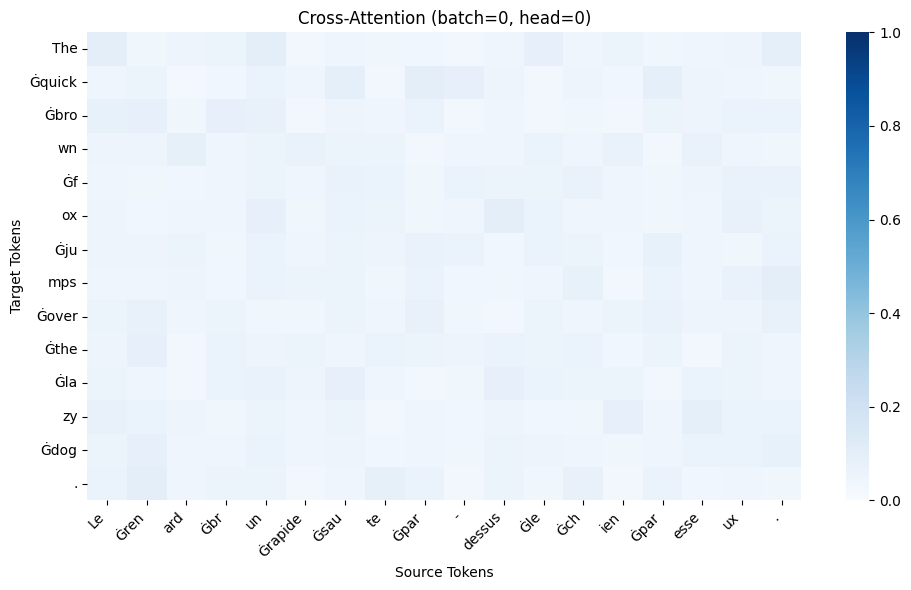

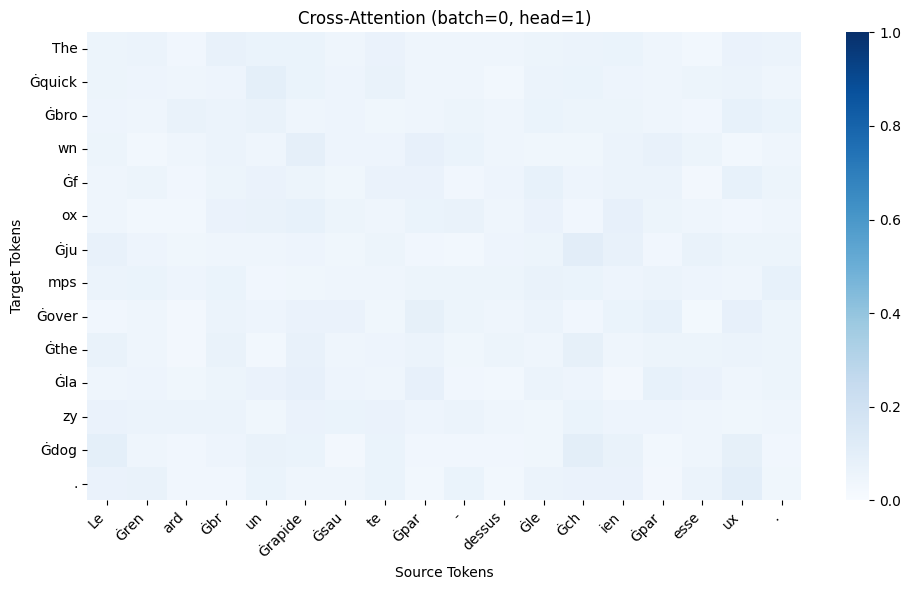

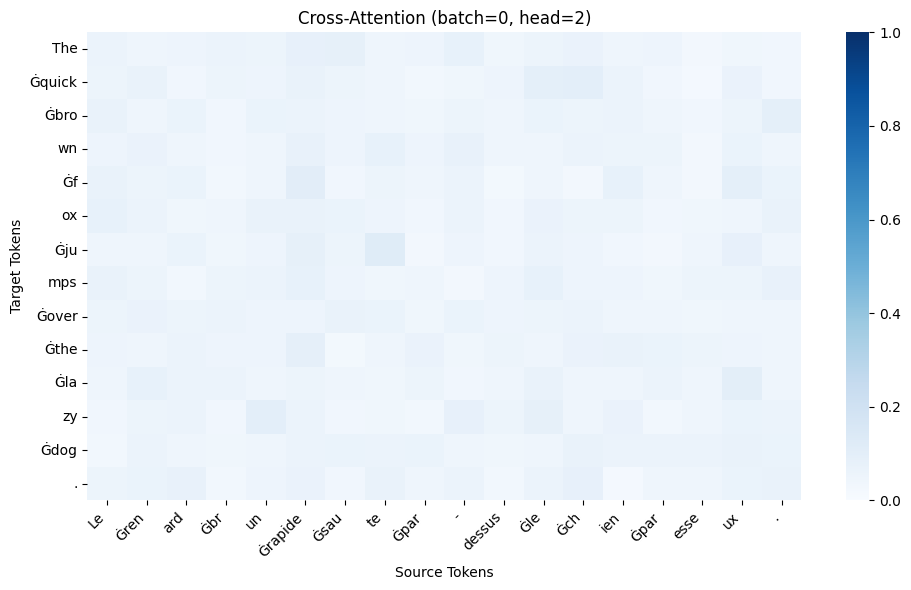

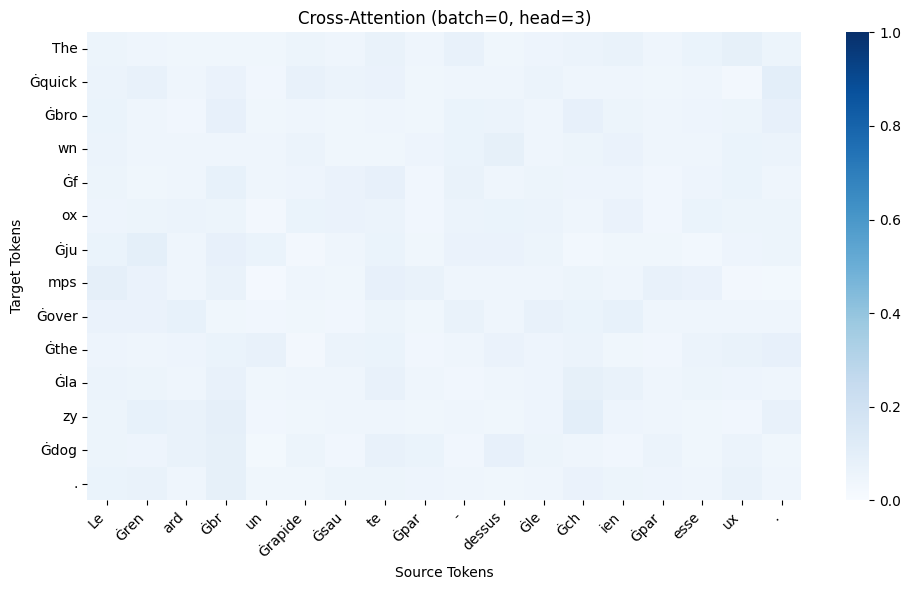

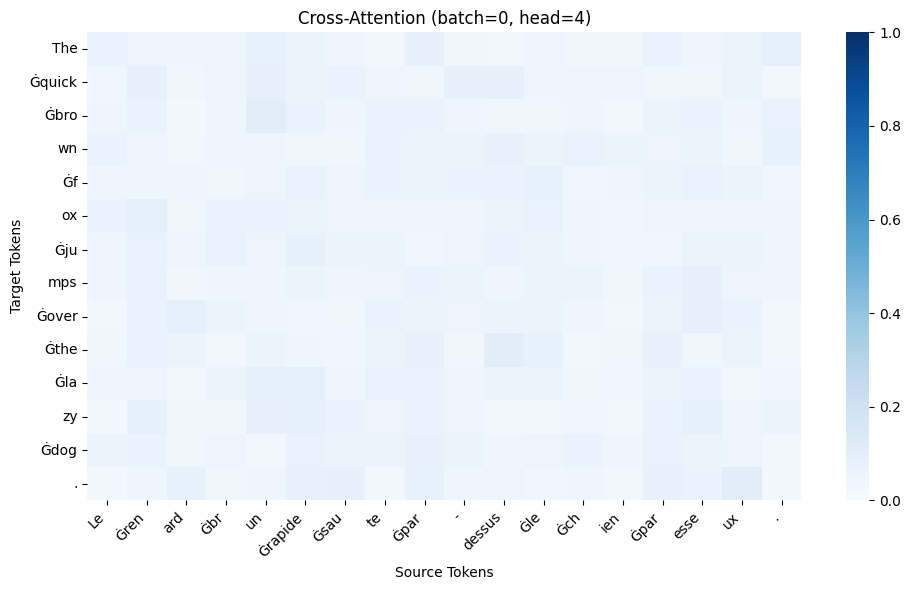

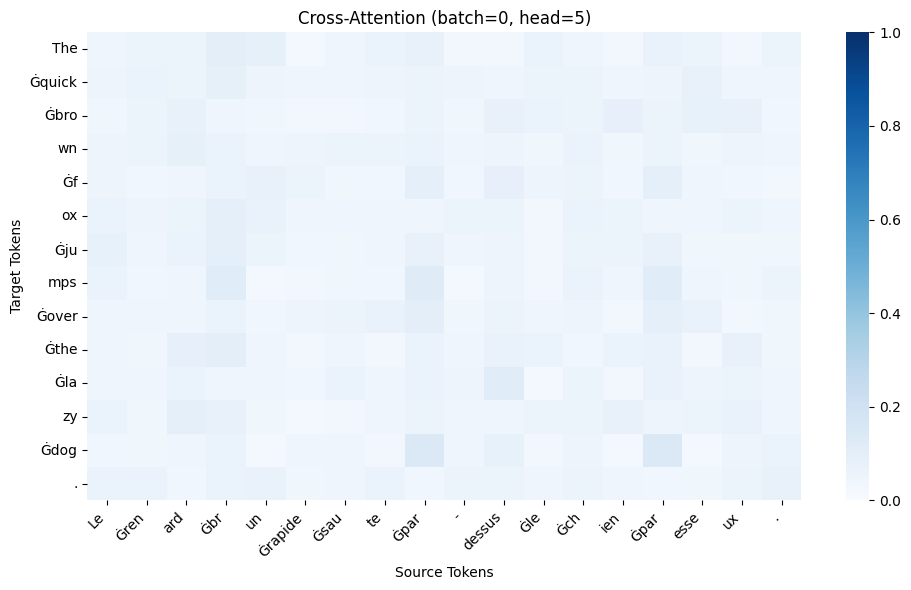

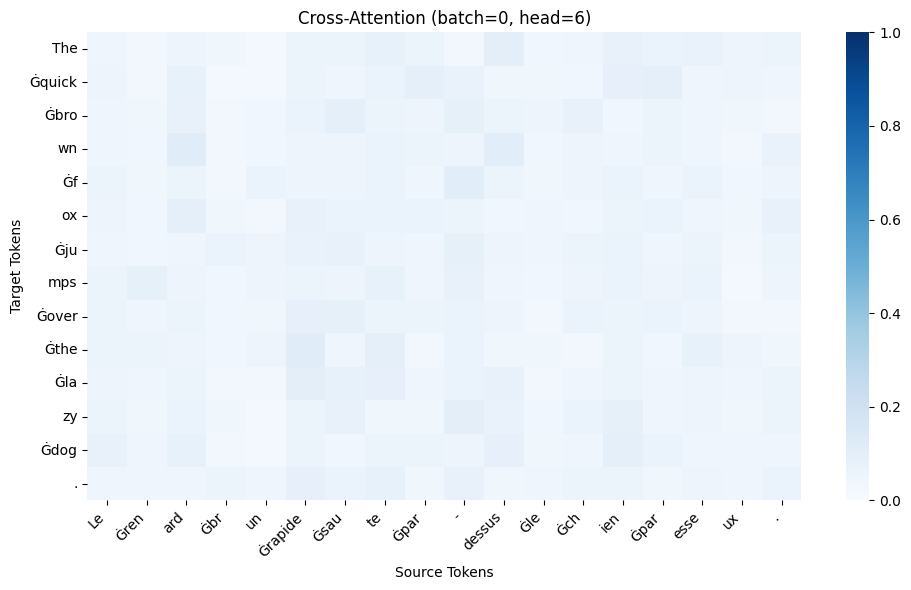

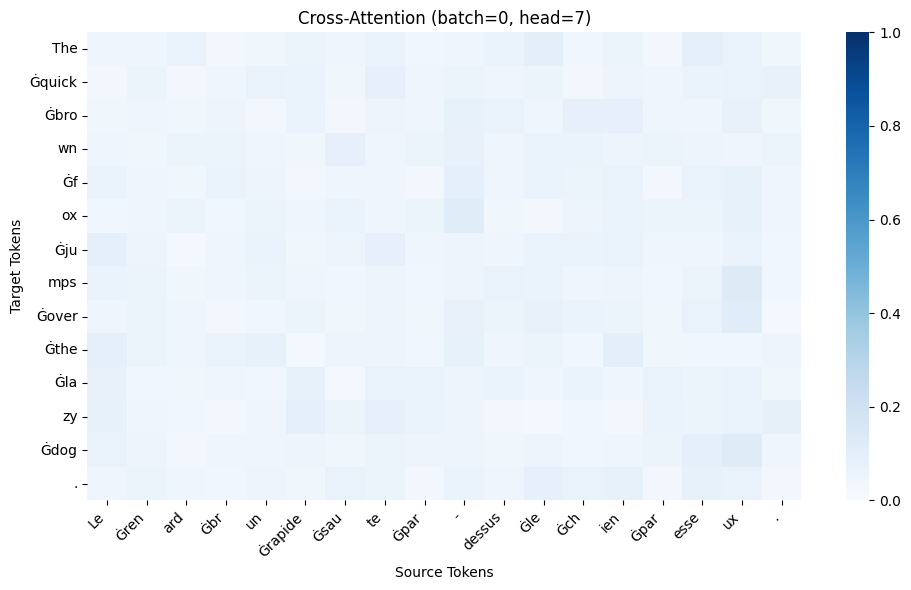

In [24]:
src_val = "Le renard brun rapide saute par-dessus le chien paresseux."
tgt_val = "The quick brown fox jumps over the lazy dog."

# Tokenize the source and target
src_tokens_val = hf_tokenizer(src_val, return_tensors='pt', padding=True, truncation=True, max_length=max_len).to(device)
tgt_tokens_val = hf_tokenizer(tgt_val, return_tensors='pt', padding=True, truncation=True, max_length=max_len).to(device)

print(src_tokens_val["input_ids"].shape)
print(tgt_tokens_val["input_ids"].shape)

# Run the model
model.eval()
with torch.no_grad():
    logits, attn_weights = model(
        src=src_tokens_val['input_ids'],
        tgt=tgt_tokens_val['input_ids'],
        src_mask=src_tokens_val['attention_mask'],
        tgt_mask=tgt_tokens_val['attention_mask']
    )

# Decode the source and target sequences
src_tokens = hf_tokenizer.convert_ids_to_tokens(src_tokens_val["input_ids"][0])
tgt_tokens = hf_tokenizer.convert_ids_to_tokens(tgt_tokens_val["input_ids"][0])

# Visualize the attention weights
for i in range(num_heads):
    visualize_cross_attention(
        attn_weights=attn_weights,
        source_tokens=src_tokens,
        target_tokens=tgt_tokens,
        batch_idx=0,
        head_idx=i
    )

## Congrats! You can now train a simple machine translator by your own ;)